In [2]:
import torch
import torch.nn as nn
from torchvision.models import vgg19_bn , VGG19_BN_Weights
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import Normalize, ToTensor, Compose
import os
import PIL
from PIL import Image
import math

In [3]:
model = vgg19_bn()

for name, child in model.named_children():
    print(name)
    print(child)

features
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace=True)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace=True)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), pad

In [4]:
class UNET(nn.Module):
    def __init__(self, encoder, center, decoder):
        super().__init__()
        self.encoder = encoder
        self.center = center
        self.decoder = decoder

    def forward(self, x):
        encoder_outputs = self.encoder(x)
        center_output = self.center(encoder_outputs[-1])
        decoder_output = self.decoder(center_output, encoder_outputs)

        return decoder_output

In [5]:
class Encoder(nn.Module):
    def __init__(self, pretrained_network):
        super().__init__()
        self.encoder = pretrained_network

    def forward(self, x):
        encoder_outputs = []

        for layers in self.encoder.features:
            x = layers(x)
            encoder_outputs.append(x)

        return encoder_outputs

In [6]:
class Encoder(nn.Module):
    def __init__(self, pretrained_network):
        super().__init__()
        self.encoder = pretrained_network

    def forward(self, x):
        encoder_outputs = []

        for layers in self.encoder.features:
            x = layers(x)
            encoder_outputs.append(x)

        return encoder_outputs

In [7]:
class Center(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(in_channels = 512, out_channels = 1024, kernel_size = (3,3), padding = 1)
        self.bn1 = nn.BatchNorm2d(1024)
        self.conv2 = nn.Conv2d(in_channels = 1024, out_channels = 1024, kernel_size = (3,3), padding = 1)
        self.bn2 = nn.BatchNorm2d(1024)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

In [8]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = nn.ReLU()
        self.conv5_up = nn.Conv2d(in_channels = 1024, out_channels = 512, kernel_size = (3,3), padding = 1)
        self.conv5_1 = nn.Conv2d(in_channels = 1024, out_channels = 512, kernel_size = (3,3), padding = 1)
        self.bn5_1 = nn.BatchNorm2d(512)
        self.conv5_2 = nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = (3,3), padding = 1)
        self.bn5_2 = nn.BatchNorm2d(512)
        self.conv5_3 = nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = (3,3), padding = 1)
        self.bn5_3 = nn.BatchNorm2d(512)
        self.conv5_4 = nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = (3,3), padding = 1)
        self.bn5_4 = nn.BatchNorm2d(512)

        self.conv4_up = nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = (3,3), padding = 1)
        self.conv4_1 = nn.Conv2d(in_channels = 1024, out_channels = 512, kernel_size = (3,3), padding = 1)
        self.bn4_1 = nn.BatchNorm2d(512)
        self.conv4_2 = nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = (3,3), padding = 1)
        self.bn4_2 = nn.BatchNorm2d(512)
        self.conv4_3 = nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = (3,3), padding = 1)
        self.bn4_3 = nn.BatchNorm2d(512)
        self.conv4_4 = nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = (3,3), padding = 1)
        self.bn4_4 = nn.BatchNorm2d(512)

        self.conv3_up = nn.Conv2d(in_channels = 512, out_channels = 256, kernel_size = (3,3), padding = 1)
        self.conv3_1 = nn.Conv2d(in_channels = 512, out_channels = 256, kernel_size = (3,3), padding = 1)
        self.bn3_1 = nn.BatchNorm2d(256)
        self.conv3_2 = nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = (3,3), padding = 1)
        self.bn3_2 = nn.BatchNorm2d(256)
        self.conv3_3 = nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = (3,3), padding = 1)
        self.bn3_3 = nn.BatchNorm2d(256)
        self.conv3_4 = nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = (3,3), padding = 1)
        self.bn3_4 = nn.BatchNorm2d(256)

        self.conv2_up = nn.Conv2d(in_channels = 256, out_channels = 128, kernel_size = (3,3), padding = 1)
        self.conv2_1 = nn.Conv2d(in_channels = 256, out_channels = 128, kernel_size = (3,3), padding = 1)
        self.bn2_1 = nn.BatchNorm2d(128)
        self.conv2_2 = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = (3,3), padding = 1)
        self.bn2_2 = nn.BatchNorm2d(128)

        self.conv1_up = nn.Conv2d(in_channels = 128, out_channels = 64, kernel_size = (3,3), padding = 1)
        self.conv1_1 = nn.Conv2d(in_channels = 128, out_channels = 64, kernel_size = (3,3), padding = 1)
        self.bn1_1 = nn.BatchNorm2d(64)
        self.conv1_2 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = (3,3), padding = 1)
        self.bn1_2 = nn.BatchNorm2d(64)

        self.conv_final = nn.Conv2d(in_channels = 64, out_channels = 2, kernel_size = (1,1))

    def forward(self, x, encoder_outputs):
        x = F.interpolate(x, scale_factor = 2, mode = 'nearest')
        x = self.conv5_up(x)
        x = self.relu(x)
        x = torch.cat((x, encoder_outputs[51]), dim = 1)
        x = self.conv5_1(x)
        x = self.bn5_1(x)
        x = self.relu(x)
        x = self.conv5_2(x)
        x = self.bn5_2(x)
        x = self.relu(x)
        x = self.conv5_3(x)
        x = self.bn5_3(x)
        x = self.relu(x)
        x = self.conv5_4(x)
        x = self.bn5_4(x)
        x = self.relu(x)

        x = F.interpolate(x, scale_factor = 2, mode = 'nearest')
        x = self.conv4_up(x)
        x = self.relu(x)
        x = torch.cat((x, encoder_outputs[38]), dim = 1)
        x = self.conv4_1(x)
        x = self.bn4_1(x)
        x = self.relu(x)
        x = self.conv4_2(x)
        x = self.bn4_2(x)
        x = self.relu(x)
        x = self.conv4_3(x)
        x = self.bn4_3(x)
        x = self.relu(x)
        x = self.conv4_4(x)
        x = self.bn4_4(x)
        x = self.relu(x)

        x = F.interpolate(x, scale_factor = 2, mode = 'nearest')
        x = self.conv3_up(x)
        x = self.relu(x)
        x = torch.cat((x, encoder_outputs[25]), dim = 1)
        x = self.conv3_1(x)
        x = self.bn3_1(x)
        x = self.relu(x)
        x = self.conv3_2(x)
        x = self.bn3_2(x)
        x = self.relu(x)
        x = self.conv3_3(x)
        x = self.bn3_3(x)
        x = self.relu(x)
        x = self.conv3_4(x)
        x = self.bn3_4(x)
        x = self.relu(x)

        x = F.interpolate(x, scale_factor = 2, mode = 'nearest')
        x = self.conv2_up(x)
        x = self.relu(x)
        x = torch.cat((x, encoder_outputs[12]), dim = 1)
        x = self.conv2_1(x)
        x = self.bn2_1(x)
        x = self.relu(x)
        x = self.conv2_2(x)
        x = self.bn2_2(x)
        x = self.relu(x)

        x = F.interpolate(x, scale_factor = 2, mode = 'nearest')
        x = self.conv1_up(x)
        x = self.relu(x)
        x = torch.cat((x, encoder_outputs[5]), dim = 1)
        x = self.conv1_1(x)
        x = self.bn1_1(x)
        x = self.relu(x)
        x = self.conv1_2(x)
        x = self.bn1_2(x)
        x = self.relu(x)

        x = self.conv_final(x)

        return x

In [9]:
import torch
if torch.cuda.is_available():
    device=torch.device(type="cuda", index=0)
else:
    device=torch.device(type="cpu", index=0)

Image Type: <class 'PIL.TiffImagePlugin.TiffImageFile'>
Mask Type: <class 'PIL.GifImagePlugin.GifImageFile'>
Image Shape: (584, 565, 3) | Mask Sahpe: (584, 565)
Unique values in Mask: [  0 255]
Image Data Type: uint8
Mask Data Type: uint8


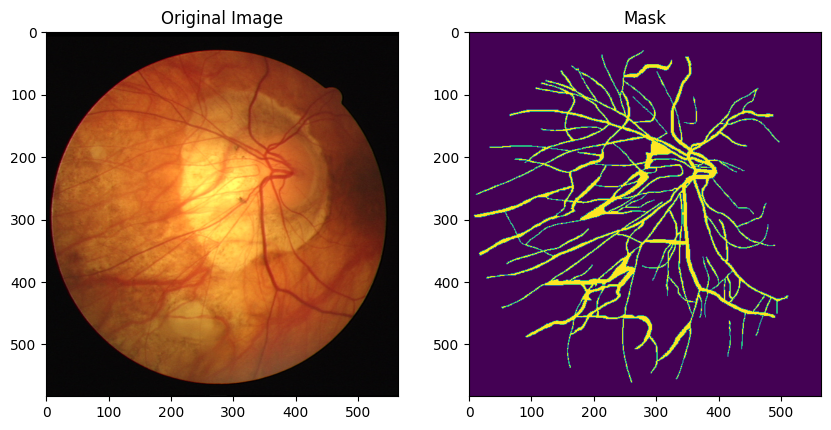

In [10]:
img = Image.open('/kaggle/input/sai-vessel-segmentation2/all/train/34_training.tif')
mask = Image.open('/kaggle/input/sai-vessel-segmentation2/all/train/34_manual1.gif')

print("Image Type:", type(img))
print("Mask Type:", type(mask))
print(f"Image Shape: {np.array(img).shape} | Mask Sahpe: {np.array(mask).shape}")

print("Unique values in Mask:",np.unique(mask))
print("Image Data Type:", np.array(img).dtype)
print("Mask Data Type:", np.array(mask).dtype)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Original Image")
plt.imshow(img)
plt.subplot(1,2,2)
plt.title("Mask")
plt.imshow(mask)
plt.show()

In [11]:
def reshape(path):
    original_image = Image.open(path)
    reshaped_image = original_image.resize((512,512), PIL.Image.NEAREST)
    return reshaped_image

Image Type: <class 'PIL.Image.Image'>
Mask Type: <class 'PIL.Image.Image'>
Image Shape: (512, 512, 3) | Mask Sahpe: (512, 512)
Unique values in Mask: [  0 255]
Image Data Type: uint8
Mask Data Type: uint8


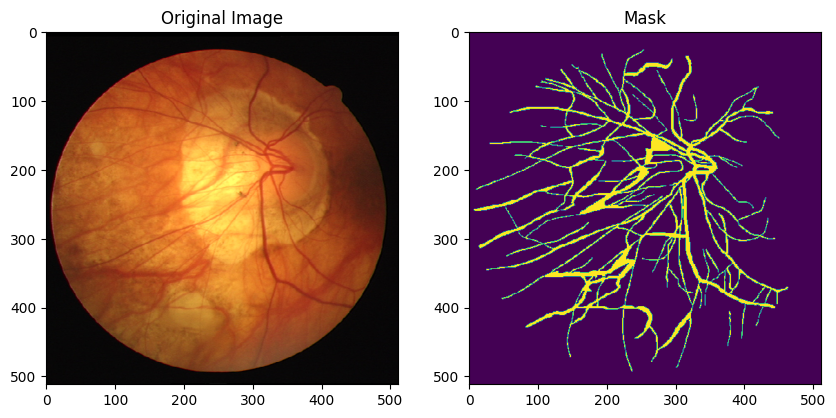

In [12]:
img = reshape('/kaggle/input/sai-vessel-segmentation2/all/train/34_training.tif')
mask = reshape('/kaggle/input/sai-vessel-segmentation2/all/train/34_manual1.gif')

print("Image Type:", type(img))
print("Mask Type:", type(mask))
print(f"Image Shape: {np.array(img).shape} | Mask Sahpe: {np.array(mask).shape}")

print("Unique values in Mask:",np.unique(mask))
print("Image Data Type:", np.array(img).dtype)
print("Mask Data Type:", np.array(mask).dtype)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Original Image")
plt.imshow(img)
plt.subplot(1,2,2)
plt.title("Mask")
plt.imshow(mask)
plt.show()

In [13]:
class TrainDataset(Dataset):
    def __init__(self, path, transform = None):
        super().__init__()
        self.path = path
        _,_,self.files = next(os.walk(path))
        self.length = int(len(self.files)/2) - 4
        self.transform = Compose([ToTensor(), Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        idx = idx + 21
        path = self.path + str(idx) + "_training.tif"
        img = reshape(path)
        img = self.transform(img)

        path = self.path + str(idx) + "_manual1.gif"
        mask = reshape(path)
        mask = np.array(mask)
        mask = torch.from_numpy(mask).type(torch.long)
        mask[mask == 255] = 1

        return img,mask

class ValidationDataset(Dataset):
    def __init__(self, path, transform = None):
        super().__init__()
        self.path = path
        _,_,self.files = next(os.walk(path))
        self.length = int(len(self.files)/2) - 16
        self.transform = Compose([ToTensor(), Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        idx = idx + 37
        path = self.path + str(idx) + "_training.tif"
        img = reshape(path)
        img = self.transform(img)

        path = self.path + str(idx) + "_manual1.gif"
        mask = reshape(path)
        mask = np.array(mask)
        mask = torch.from_numpy(mask).type(torch.long)
        mask[mask == 255] = 1

        return img,mask

In [14]:
train_dataset = TrainDataset("/kaggle/input/sai-vessel-segmentation2/all/train/")
validation_dataset = ValidationDataset("/kaggle/input/sai-vessel-segmentation2/all/train/")

batch_size = 4
train_dataloader = DataLoader(train_dataset, batch_size, shuffle = True)
validation_dataloader = DataLoader(validation_dataset, batch_size)

Image Shape: torch.Size([3, 512, 512]) Mask Shape: torch.Size([512, 512]) Image dtype: torch.float32 Mask dtype: torch.int64
Unique values in Mask: [0 1]


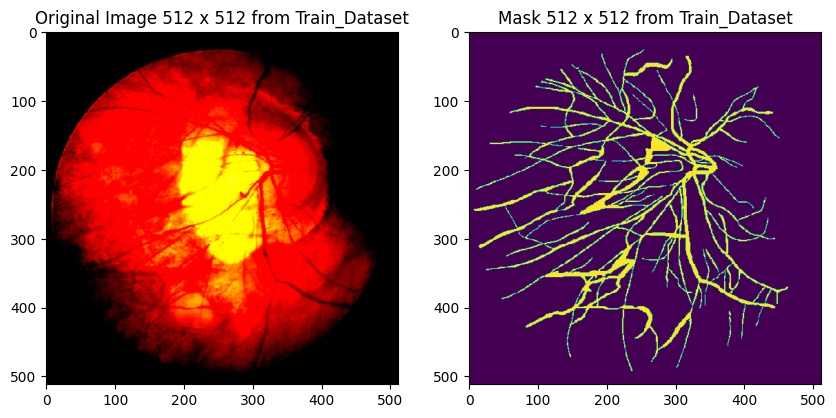

In [15]:
img,mask=train_dataset[13]

print("Image Shape:",img.shape,"Mask Shape:",mask.shape,"Image dtype:",img.dtype, "Mask dtype:", mask.dtype)
print("Unique values in Mask:",np.unique(mask))

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Original Image 512 x 512 from Train_Dataset")
plt.imshow(torch.permute(img,(1,2,0)))

plt.subplot(1,2,2)
plt.title("Mask 512 x 512 from Train_Dataset")
plt.imshow(mask)
plt.show()

In [16]:
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    model.train()
    track_loss = 0
    XintY = 0
    X = 0
    Y = 0
    for i, (imgs, masks) in enumerate(dataloader):
        imgs = imgs.to(device)
        masks = masks.to(device)

        preds = model(imgs)

        loss = loss_fn(preds,masks)

        track_loss += loss.item()

        predclass = torch.argmax(preds,dim=1)

        Y += predclass.sum().item()
        X += masks.sum().item()


        predclass[predclass==0] = 2

        XintY += (predclass==masks).type(torch.float).sum().item()

        print("Trainig Batch",i+1,":","2*XintY:",2*XintY,"X:",X,"Y:",Y, "X+Y:",X+Y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        running_loss = round(track_loss/(i+1),2)
        running_dice_coef = round(((2*XintY)/(X+Y)),2)

        print("Training Batch", i+1,":","/",len(dataloader), "Running Loss:",running_loss, "Running Dice_Coef:",running_dice_coef)

    epoch_loss = running_loss
    epoch_dice_coef = running_dice_coef
    return epoch_loss, epoch_dice_coef


def validation_one_epoch(dataloader, model,loss_fn):
    model.eval()
    track_loss = 0
    XintY = 0
    X = 0
    Y = 0
    with torch.no_grad():
        for i, (imgs, masks) in enumerate(dataloader):
            imgs = imgs.to(device)
            masks = masks.to(device)

            preds = model(imgs)

            loss = loss_fn(preds,masks)

            track_loss += loss.item()

            predclass = torch.argmax(preds,dim=1)

            Y += predclass.sum().item()
            X += masks.sum().item()

            predclass[predclass==0] = 2

            XintY += (predclass==masks).type(torch.float).sum().item()

            print("Validation Batch",i+1,":","2*XintY:",2*XintY,"X:",X,"Y:",Y, "X+Y:",X+Y)


            running_loss = round(track_loss/(i+1),2)
            running_dice_coef = round(((2*XintY)/(X+Y)),2)

            print("Validation Batch", i+1,":","/",len(dataloader), "Running Loss:",running_loss, "Running Dice_Coef:",running_dice_coef)

    epoch_loss = running_loss
    epoch_dice_coef = running_dice_coef
    return epoch_loss, epoch_dice_coef

In [17]:
pretrained_network = vgg19_bn(weights = VGG19_BN_Weights.DEFAULT)

for param in pretrained_network.features.parameters():
    param.requires_grad = False

encoder = Encoder(pretrained_network).to(device)
center = Center().to(device)
decoder = Decoder().to(device)

model = UNET(encoder,center, decoder).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.001)
epochs = 10

for i in range(epochs):
    print("Epoch No:",i+1)
    train_epoch_loss, train_epoch_dice_coef=train_one_epoch(train_dataloader,model,loss_fn,optimizer)
    print("Training Epoch Loss:", train_epoch_loss, "Training Epoch Dice_Coef:", train_epoch_dice_coef)
    val_epoch_loss, val_epoch_dice_coef = validation_one_epoch(validation_dataloader,model,loss_fn)
    print("Validation Epoch Loss:", val_epoch_loss, "Validation Epoch Dice_Coef:", val_epoch_dice_coef)
    print("--------------------------------------------------")


for param in pretrained_network.features.parameters():
    param.requires_grad=True

for i in range(epochs):
    print("Epoch No:",i+1)
    train_epoch_loss, train_epoch_dice_coef=train_one_epoch(train_dataloader,model,loss_fn,optimizer)
    print("Training Epoch Loss:", train_epoch_loss, "Training Epoch Dice_Coef:", train_epoch_dice_coef)
    val_epoch_loss, val_epoch_dice_coef=validation_one_epoch(validation_dataloader,model,loss_fn)
    print("Validation Epoch Loss:", val_epoch_loss, "Validation Epoch Dice_Coef:", val_epoch_dice_coef)
    print("--------------------------------------------------")

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth
100%|██████████| 548M/548M [00:06<00:00, 87.6MB/s] 


Epoch No: 1
Trainig Batch 1 : 2*XintY: 91296.0 X: 95010 Y: 563679 X+Y: 658689
Training Batch 1 : / 4 Running Loss: 0.72 Running Dice_Coef: 0.14
Trainig Batch 2 : 2*XintY: 248284.0 X: 189029 Y: 940385 X+Y: 1129414
Training Batch 2 : / 4 Running Loss: 0.69 Running Dice_Coef: 0.22
Trainig Batch 3 : 2*XintY: 389960.0 X: 278885 Y: 1153241 X+Y: 1432126
Training Batch 3 : / 4 Running Loss: 0.64 Running Dice_Coef: 0.27
Trainig Batch 4 : 2*XintY: 501384.0 X: 364581 Y: 1268328 X+Y: 1632909
Training Batch 4 : / 4 Running Loss: 0.6 Running Dice_Coef: 0.31
Training Epoch Loss: 0.6 Training Epoch Dice_Coef: 0.31
Validation Batch 1 : 2*XintY: 70346.0 X: 88013 Y: 143834 X+Y: 231847
Validation Batch 1 : / 1 Running Loss: 1.01 Running Dice_Coef: 0.3
Validation Epoch Loss: 1.01 Validation Epoch Dice_Coef: 0.3
--------------------------------------------------
Epoch No: 2
Trainig Batch 1 : 2*XintY: 108970.0 X: 99959 Y: 75572 X+Y: 175531
Training Batch 1 : / 4 Running Loss: 0.41 Running Dice_Coef: 0.62
Tra

In [20]:
class FinalTrainDataset(Dataset):
    def __init__(self, path, transform = None):
        super().__init__()
        self.path = path
        _,_,self.files = next(os.walk(path))
        self.length = int(len(self.files)/2)
        self.transform = Compose([ToTensor(), Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        idx = idx + 21
        path = self.path + str(idx) + "_training.tif"
        img = reshape(path)
        img = self.transform(img)

        path = self.path + str(idx) + "_manual1.gif"
        mask = reshape(path)
        mask = np.array(mask)
        mask = torch.from_numpy(mask).type(torch.long)
        mask[mask == 255] = 1

        return img,mask

In [21]:
train_dataset = FinalTrainDataset("/kaggle/input/sai-vessel-segmentation2/all/train/")
train_dataloader = DataLoader(train_dataset, batch_size, True)

for i in range(epochs):
    print("Epoch No:",i+1)
    train_epoch_loss, train_epoch_dice_coef=train_one_epoch(train_dataloader,model,loss_fn,optimizer)
    print("Training Epoch Loss:", train_epoch_loss, "Training Epoch Dice_Coef:", train_epoch_dice_coef)
    print("--------------------------------------------------")

Epoch No: 1
Trainig Batch 1 : 2*XintY: 141620.0 X: 92236 Y: 82716 X+Y: 174952
Training Batch 1 : / 5 Running Loss: 0.09 Running Dice_Coef: 0.81
Trainig Batch 2 : 2*XintY: 280528.0 X: 181325 Y: 171631 X+Y: 352956
Training Batch 2 : / 5 Running Loss: 0.09 Running Dice_Coef: 0.79
Trainig Batch 3 : 2*XintY: 423804.0 X: 272152 Y: 257153 X+Y: 529305
Training Batch 3 : / 5 Running Loss: 0.09 Running Dice_Coef: 0.8
Trainig Batch 4 : 2*XintY: 566784.0 X: 366228 Y: 342818 X+Y: 709046
Training Batch 4 : / 5 Running Loss: 0.09 Running Dice_Coef: 0.8
Trainig Batch 5 : 2*XintY: 706338.0 X: 452594 Y: 425208 X+Y: 877802
Training Batch 5 : / 5 Running Loss: 0.09 Running Dice_Coef: 0.8
Training Epoch Loss: 0.09 Training Epoch Dice_Coef: 0.8
--------------------------------------------------
Epoch No: 2
Trainig Batch 1 : 2*XintY: 139628.0 X: 90133 Y: 82272 X+Y: 172405
Training Batch 1 : / 5 Running Loss: 0.09 Running Dice_Coef: 0.81
Trainig Batch 2 : 2*XintY: 272674.0 X: 181262 Y: 157119 X+Y: 338381
Trai

In [22]:
class TestDataset(Dataset):
    def __init__(self, path, transform = None):
        super().__init__()
        self.path = path
        _,_,self.files = next(os.walk(path))
        self.length = int(len(self.files))
        self.transform = Compose([ToTensor(), Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        idx = idx + 1
        if idx <= 9:
            path = self.path + "0" + str(idx) + "_test.tif"
        else:
            path = self.path + str(idx) + "_test.tif"

        img = reshape(path)
        img = self.transform(img)

        return img

In [23]:
test_dataset = TestDataset("/kaggle/input/sai-vessel-segmentation2/all/test/")
test_dataloader = DataLoader(test_dataset, batch_size = 2)

In [25]:
def eval_one_epoch(dataloader, model):
    model.eval()
    outputs = []
    for i, imgs in enumerate(dataloader):
        imgs = imgs.to(device)
        preds = model(imgs)

        with torch.no_grad():
            for i in range(preds.shape[0]):
                pred = preds[i,:,:,:]
                pred = torch.argmax(pred,dim = 0)
                predf = pred.flatten().cpu()
                pixelidx = np.where(predf==1)[0]+1

                run_lengths = []

                for pxid in pixelidx:
                    if len(run_lengths) == 0:
                        run_lengths.extend((pxid,1))
                    elif pxid > prev+1:
                        run_lengths.extend((pxid,1))
                    else:
                        run_lengths[-1] += 1
                    prev=pxid

                output = ' '.join([str(r) for r in run_lengths])

                outputs.append(output)
    return outputs

outputs = eval_one_epoch(test_dataloader,model)
df = pd.DataFrame(columns=['Id','Predicted'])
df['Id'] = [str(i) for i in range(20)]
df['Predicted'] = outputs
df.to_csv("submission.csv", index=None)
df

,Id,Predicted
0,0,15109 1 15621 2 16105 2 16133 2 16164 1 16617 ...
1,1,15103 3 15616 2 16128 5 16641 6 16659 1 17154 ...
2,2,15055 2 15113 2 15566 3 15621 5 15666 5 16078 ...
3,3,14071 5 14583 5 15096 5 15609 4 15665 1 16121 ...
4,4,16642 3 16676 2 17153 3 17188 3 17664 3 17699 ...
5,5,16677 2 17189 2 17700 4 18118 1 18213 6 18628 ...
6,6,16104 1 16614 5 16656 2 17127 5 17168 2 17641 ...
7,7,15080 3 15591 4 16104 4 16617 5 16657 3 17130 ...
8,8,14614 3 15126 3 15602 2 15636 5 16115 2 16147 ...
9,9,16128 2 16601 2 16640 2 17111 5 17153 2 17624 ...
